# Relation tagger

In [1]:
import os
import geopandas as gpd
import pandas as pd
from tqdm import tqdm

blocks_gdf = gpd.read_parquet('./data/blocks.parquet')[['geometry']]
blocks_gdf.head()

,geometry
0,"POLYGON ((354918.622 6625258.829, 354901.464 6..."
1,"POLYGON ((355412.142 6623378.149, 355411.7 662..."
2,"POLYGON ((353934.329 6625429.433, 353923.453 6..."
3,"POLYGON ((355099.099 6623847.765, 355074.808 6..."
4,"POLYGON ((352766.168 6621954.748, 352744.412 6..."


Читаем файлы

In [2]:
from my_package.methods.relation_tagger import RelationTagger

gdfs = RelationTagger.read_objects_gdfs('./data/services')

2025-01-18 15:24:46.996 | ERROR    | my_package.methods.relation_tagger:_read_objects_gdf:178 -  Can't read file ./data/services/child_hospital.geojson
2025-01-18 15:24:46.997 | ERROR    | my_package.methods.relation_tagger:_read_objects_gdf:178 -  Can't read file ./data/services/child_polyclinic.geojson
2025-01-18 15:24:46.998 | ERROR    | my_package.methods.relation_tagger:_read_objects_gdf:178 -  Can't read file ./data/services/dentist.geojson
2025-01-18 15:24:47.006 | SUCCESS  | my_package.methods.relation_tagger:_read_objects_gdf:176 - File read ./data/services/hospital.geojson
2025-01-18 15:24:47.021 | SUCCESS  | my_package.methods.relation_tagger:_read_objects_gdf:176 - File read ./data/services/polyclinic.geojson
2025-01-18 15:24:47.028 | SUCCESS  | my_package.methods.relation_tagger:_read_objects_gdf:176 - File read ./data/services/roddom.geojson
2025-01-18 15:24:47.029 | ERROR    | my_package.methods.relation_tagger:_read_objects_gdf:178 -  Can't read file ./data/services/tra

In [4]:
rt = RelationTagger(blocks_gdf, gdfs)
relation_gdf = rt.run()
relation_gdf.head()

100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


,geometry,Tag.MEDICAL_FACILITIES,Tag.EDUCATIONAL_FACILITIES,Tag.SPORTS_FACILITIES,Tag.COMMERCIAL_FACILITIES,Tag.CULTURAL_FACILITIES,Tag.RECREATIONAL_FACILITIES,tags
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",True,True,False,True,True,False,"[Tag.MEDICAL_FACILITIES, Tag.EDUCATIONAL_FACIL..."
1,"POLYGON ((355412.142 6623378.149, 355411.7 662...",False,True,False,True,False,True,"[Tag.EDUCATIONAL_FACILITIES, Tag.COMMERCIAL_FA..."
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",False,True,False,False,False,False,[Tag.EDUCATIONAL_FACILITIES]
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",False,True,False,False,False,False,[Tag.EDUCATIONAL_FACILITIES]
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",False,True,False,True,True,True,"[Tag.EDUCATIONAL_FACILITIES, Tag.COMMERCIAL_FA..."


Вывод по каждому тегу

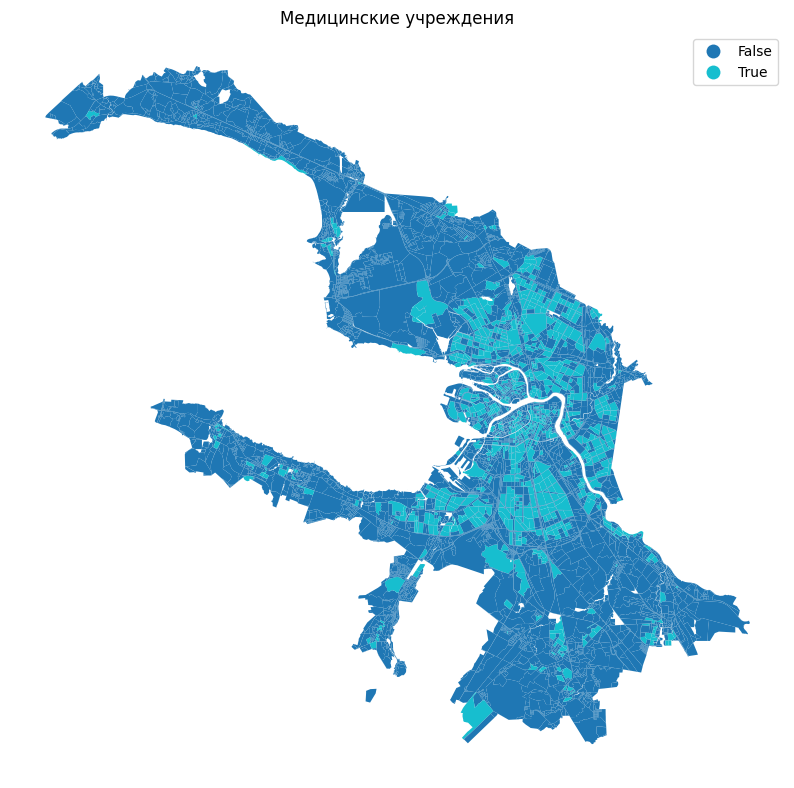

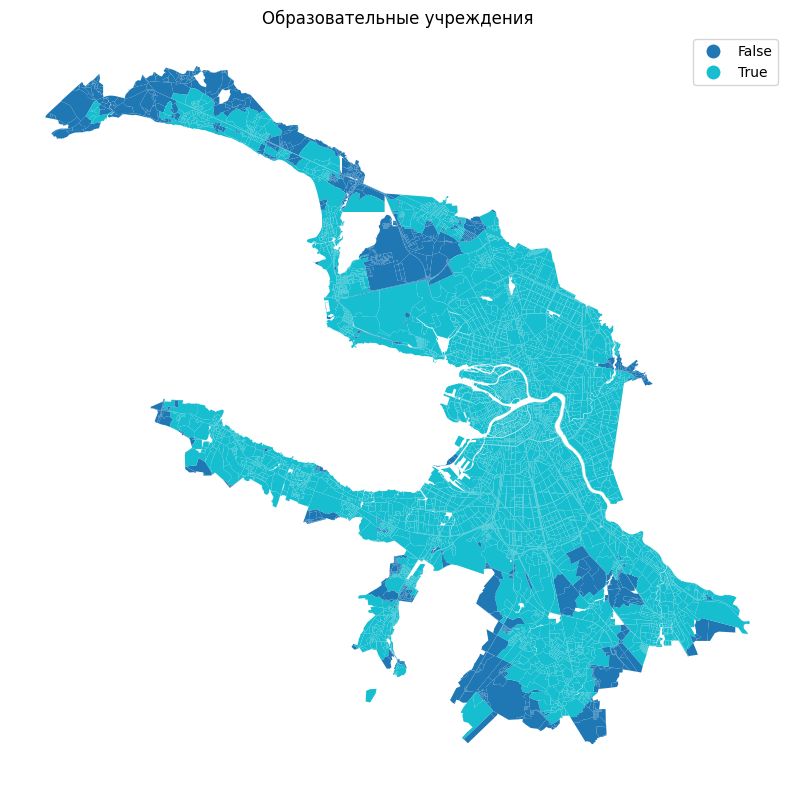

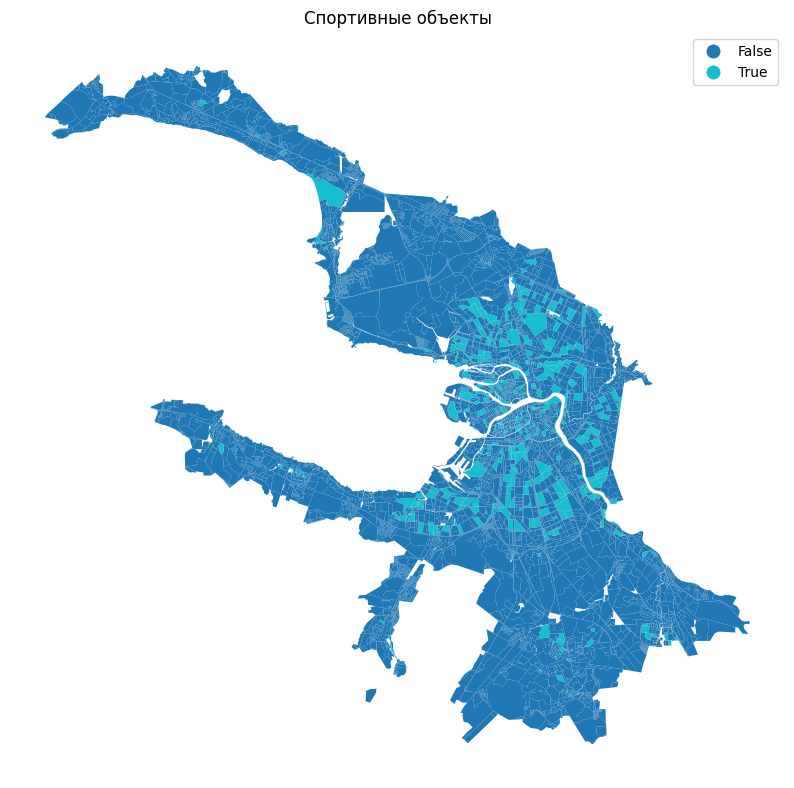

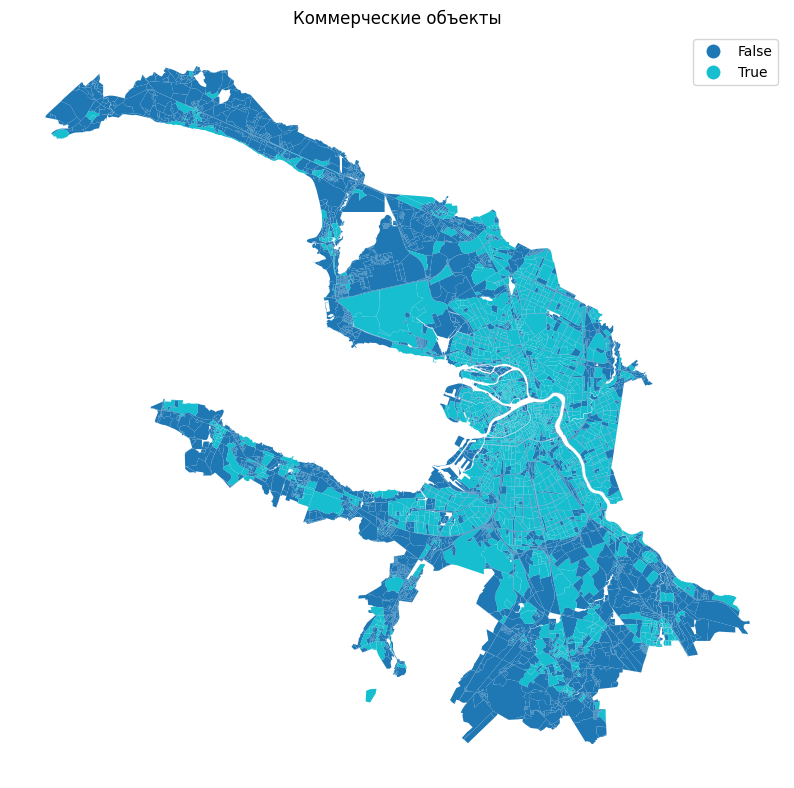

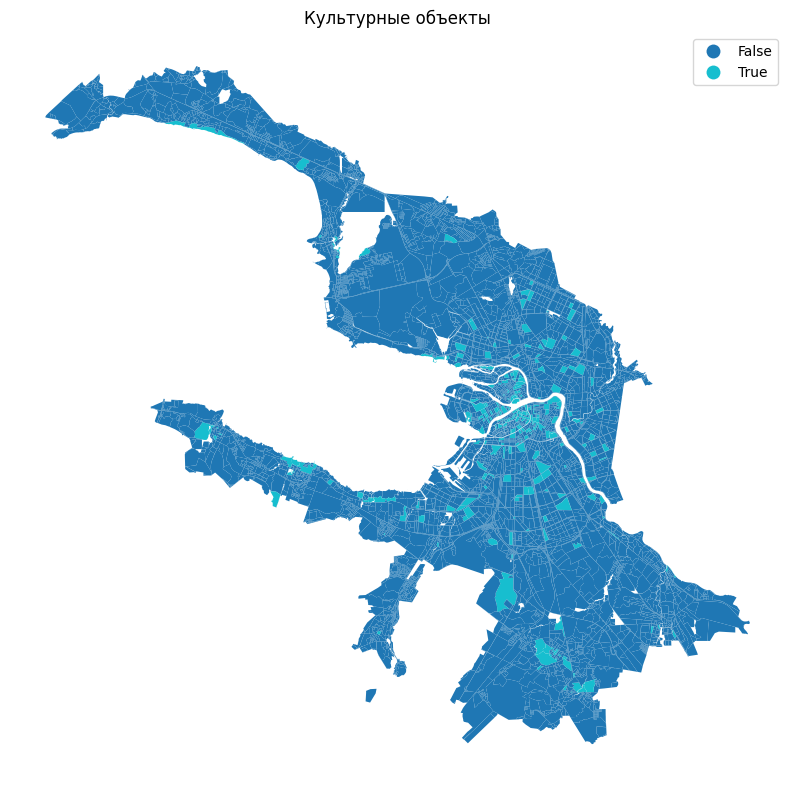

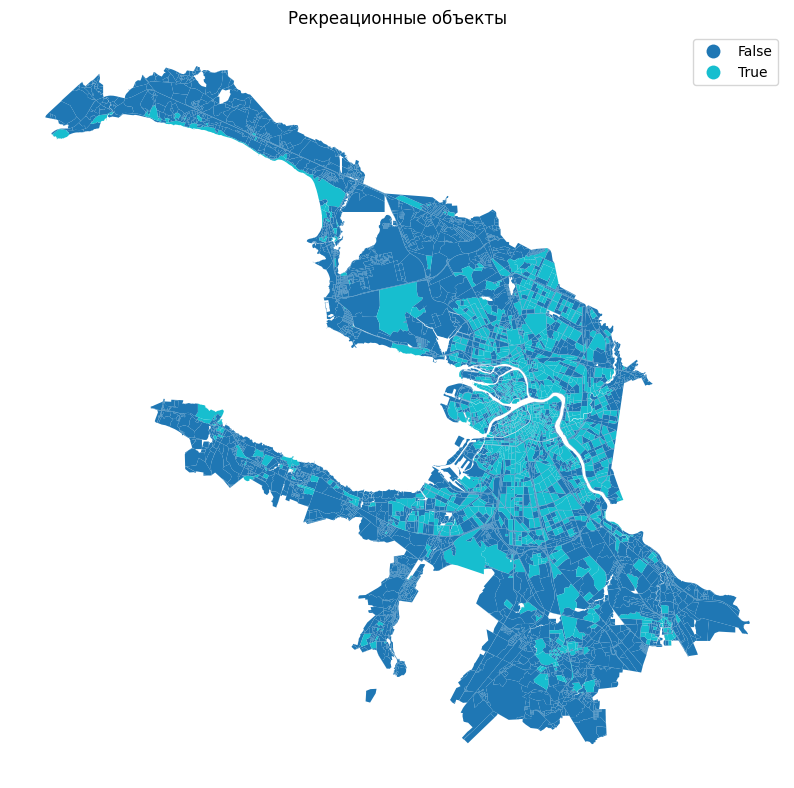

In [8]:
from my_package.models.tag import Tag

for column in relation_gdf.columns:
    if not isinstance(column, Tag):
        continue
    tag = column
    ax = relation_gdf.plot(column=tag, legend=True, figsize=(10,10))
    ax.set_title(tag.value)
    ax.set_axis_off()

Создаем буфер у каждого сервиса

In [164]:
def build_buffer_zone(gdf, service_radius_dict):
    gdf['buffer'] = gdf.apply(
    lambda row: row['geometry'].buffer(service_radius_dict.get(row['SERVICE'])), axis=1)
    return gdf

In [165]:
MED_buffer = build_buffer_zone(MED_gdf, MEDICAL_FACILITIES_tags)

In [166]:
print(MED_buffer.crs)

EPSG:3857


In [167]:
MED_buffer.head()

,geometry,SERVICE,buffer
0,POINT (3369346.324 8386906.143),child_hospital,"POLYGON ((3369846.324 8386906.143, 3369843.916..."
1,POINT (3377174.755 8400712.222),child_hospital,"POLYGON ((3377674.755 8400712.222, 3377672.348..."
2,POINT (3370911.698 8387919.457),child_hospital,"POLYGON ((3371411.698 8387919.457, 3371409.291..."
3,POINT (3381680.542 8335560.029),child_hospital,"POLYGON ((3382180.542 8335560.029, 3382178.135..."
4,POINT (3360276.457 8363686.129),child_hospital,"POLYGON ((3360776.457 8363686.129, 3360774.049..."


Пересечение сервисов и кварталов

In [168]:
#загружаем геометрию кварталов
blocks_gdf = gpd.read_file("C:/repos/master-plan-requirements/data/blocks_object_tagger.geojson")

In [169]:
blocks_gdf = blocks_gdf.to_crs(epsg=3857)

In [170]:
def create_service_table(blocks_gdf, service_tags):
    # Добавляем столбцы для каждого сервиса с начальными значениями 0
    for service in service_tags.keys():
        blocks_gdf[service] = 0

    # Добавляем столбцы для каждого сервиса с начальными значениями 0
    for service in service_tags.keys():
        blocks_gdf['SERVICE'] = 0

    return blocks_gdf

In [171]:
MED_blocks_gdf = create_service_table(blocks_gdf, MEDICAL_FACILITIES_tags)
MED_blocks_gdf.head(1)

NameError: name 'create_service_table' is not defined

In [172]:
print(MED_blocks_gdf.crs)

EPSG:3857


In [173]:
def check_intersection(blocks_gdf, buffer_gdf, service_tags):
    for idx, block in tqdm(blocks_gdf.iterrows(), total=blocks_gdf.shape[0], desc="Processing blocks"):
        for service in service_tags.keys():
            # Получаем буферы для текущего сервиса
            relevant_buffers = buffer_gdf.loc[buffer_gdf['SERVICE'] == service, 'geometry']
            
            if not relevant_buffers.empty:
                for buffer_geom in relevant_buffers:
                    intersection = block['geometry'].intersection(buffer_geom)
                    # Проверяем, пересекается ли хотя бы 30% буфера
                    if intersection.area >= 0.3 * buffer_geom.area:
                        blocks_gdf.at[idx, service] = 1
    
    # Устанавливаем столбец 'SERVICE' для блоков, которые пересекаются с хотя бы одним сервисом
    blocks_gdf['SERVICE'] = blocks_gdf.apply(
        lambda row: 1 if any(row[service] == 1 for service in service_tags.keys()) else 1,
        axis=1
    )
    
    return blocks_gdf

In [174]:
MED_blocks_service_gdf = check_intersection(MED_blocks_gdf, MED_buffer, MEDICAL_FACILITIES_tags)

Processing blocks: 100%|██████████| 3839/3839 [02:47<00:00, 22.97it/s]


In [175]:
MED_blocks_service_gdf.head(1)

,id,geometry,child_hospital,child_polyclinic,dentist,SERVICE
0,0,"POLYGON ((3385731.840 8387954.044, 3385731.840...",1,1,1,1
